In [1]:
%matplotlib inline

import pandas as pd
import pylab as plt
import numpy as np
import scipy as sc
import scipy.stats
import math

# Modelling

In this notebook, we will try to build a model for predicting yield in the Univeristy of California system. We will try to achieve the goal by:
 - predicting the yield for each high school
 - combining the predicted yields into a single yield for all high schools
 
In other words, we will try to predict the `yield` column given other columns (besides the data about enrolled students).

## Loading the data

### Incorporating the New Dataset

First, we will load our data. Our dataset contains some extra columns for schools in California:
 - AP scores
 - SAT scores
 - Senior class enrollment
 - Distances to UC campuses
 
That is why we will only perform our modelling in the state of California. Moreover, since our ethnicty data is very erratic, we will only use the cumulative data (`data['ethnicity'] == 'All'`).

In [40]:
data = pd.read_csv("data/with_scores.csv")
data = data[data['state']=='California']
data = data[data['campus'] != 'Universitywide']
data = data[data['year']]
data = data[data['ethnicity'] == 'All']

KeyError: '[1994. 1994. 1994. ... 2017. 2017. 2017.] not in index'

## Choosing the features

The overall plan is to select the newly added features i.e. various test scores, combining with our old features, and generate a linear regression model to make predictions.

First of all, we should take a look of the new dataset. We have a large number of NaNs in the test-score fields, so we might need to drop them if needed. 

In [ ]:
data.columns

check how many NaN's are there in each field 

In [ ]:
count_nan = len(data) - data.count()
count_nan

After careful consideration we decided to use the features in `train_cols` below for training. Some of the factors we considered:

- We should not include all of `sat_total_avg`, `sat_math_avg`, `sat_verbal_avg` - since each is a linear combination of the other two.
- We must not use the `enr_*` fields since that would cause bleeding of the predicted column into the training set. Moreover, no enrollment data will be available at the time of the prediction - modelling yield is only interesting if we don't know who accepted the admission offer.

In [ ]:
train_cols = [
    'year', 
    'app_num', 'adm_num', 
    'app_gpa', 'adm_gpa',
    'distance',
    'ap_num_scr1', 'ap_num_scr2', 'ap_num_scr3', 'ap_num_scr4', 'ap_num_scr5',
    'ap_num_test_takers',
    'enroll12',
    'sat_total_avg', 'sat_num_test_takers'
]
pred_col = ['yield']

def get_data_for_campus(df, campus_name):
     return df[df['campus'] == campus_name].dropna()
    

Next, we will inspect example training and testing data.

In [ ]:
berkeley_data = get_data_for_campus(data, 'Berkeley')
berkeley_data[train_cols].describe().T

In [ ]:
berkeley_data[pred_col].describe()

In [ ]:
for col in train_cols:
    plt.figure()
    plt.title(col)
    berkeley_data[col].hist(bins=20)

## Using Z-scores in our model

To make sure all of our data is on the same scale, we will prepare Z-Scoring functions. However, our predictions will then be outputed on the Z-Score scale, thus we will also need a function to undo the Z-Scores.

In [ ]:
def z_score(X):
    return (X-X.mean(axis=0)) / X.std(axis=0)

def z_score_from_different_data_sample(X, diff_sample):
    return (X-diff_sample.mean(axis=0)) / diff_sample.std(axis=0)

def undo_z_score(to_undo, orig_sample):
    return (to_undo * orig_sample.std(axis=0)) + orig_sample.mean(axis=0)

We will now see the distribution of our data when Z-scored (shown on the data from UC Berkeley)

In [ ]:
for col in train_cols:
    plt.figure()
    plt.title(col)
    z_score(berkeley_data[train_cols])[col].hist(bins=20)

## Splitting the data into train and test sets
We will use all early years for training, and later years for testing. This is done because universities would train and evaluate this way - only past data is available to train on.

Note that we are using the data from the training set to compute the Z-scores for both the training data and the test data. We do that to avoid our testing data bleeding into our training data.

In [ ]:
def get_training_split(df, split_ratio):
    years = df['year'].unique()
    cutoff_year = years[int(math.ceil(len(years)*split_ratio))]
    
    train_filter = df['year'] <= cutoff_year
    test_filter = df['year'] > cutoff_year
    
    inputs_training_set = df[train_cols][train_filter]
    inputs_test_set = df[train_cols][test_filter]
    
    outputs_training_set = df[pred_col][train_filter]
    outputs_test_set = df[pred_col][test_filter]
    
    result = {
        'original': df,
        'train_filter': train_filter,
        'test_filter': test_filter,
        'inputs_training_set': inputs_training_set,
        'inputs_test_set': inputs_test_set,
        'outputs_training_set': outputs_training_set,
        'outputs_test_set': outputs_test_set,
        'z_inputs_training_set': z_score_from_different_data_sample(inputs_training_set, inputs_training_set),
        'z_inputs_test_set': z_score_from_different_data_sample(inputs_test_set, inputs_training_set),
        'z_outputs_training_set': z_score_from_different_data_sample(outputs_training_set, outputs_training_set),
        'z_outputs_test_set': z_score_from_different_data_sample(outputs_test_set, outputs_training_set),
    }
    return result

## Helpers for extracting yield data from the dataset 

We have prepared a few helpers to aid the process of extracting yield data from our dataset. For example, we can build a chart, that shows the yield of each UC campus by year.

Using the chart shown below, we have also found out that UC Merced was founded in 2005 (and that is why it is missing data from previous years).

In [ ]:
def hs_name_to_code(hs_name):
    return list(df[df['school'] == hs_name]['school_num'])[0]
    
def get_hs_yield_on_campus_filtered_df(df, hs_code, year):
    data_filter = (df['school_num'] == hs_code) & (df['year'] == year)
    _yield = df[data_filter]['yield']
    try:
        return list(_yield)[0]
    except IndexError:
        return np.nan

def get_hs_yield(df, hs_code, uc_campus, year):
    return get_hs_yield_on_campus_filtered_df(
        df[df['campus'] == uc_campus],
        hs_code, year
    )
    
def get_year_yields(df):
    campuses = df['campus'].unique()
    yields = {}
    for campus in campuses:
        df_for_campus = df[df['campus'] == campus]
        enrolled_and_admitted = df_for_campus.groupby('year')[['enr_num', 'adm_num']].sum()
        yields[campus] = enrolled_and_admitted['enr_num']/enrolled_and_admitted['adm_num']
    
    return pd.DataFrame(yields)

In [ ]:
get_year_yields(data.dropna())

## Model evaluation

We will evaluate our models in two main ways:
- Root mean square as measured for each datapoint in the test dataset
- Accuracy of the prediction extended for the entire academic year

In [41]:
def rms_evaluate_model(df, hs_codes, years, predictions):
    assert(len(hs_codes) == len(years) == len(predictions))
    
    hs_codes = list(hs_codes)
    years = list(years)
    predictions = list(predictions)
    
    square_error_sum = 0
    for i in range(len(hs_codes)):
        expected = get_hs_yield_on_campus_filtered_df(df, hs_codes[i], years[i])
        square_error_sum += (expected - predictions[i])**2
    
    return (square_error_sum / len(hs_codes))**(.5)

def predictions_to_yearly(df, hs_codes, years, predictions):
    """
    Converts a model prediction (prediction by high school) into yearly predictions.
    """
    assert(len(hs_codes) == len(years) == len(predictions))
    
    hs_codes = list(hs_codes)
    years = list(years)
    predictions = list(predictions)
    
    adm_and_enr_by_year = {}
    for i in range(len(hs_codes)):
        if years[i] in adm_and_enr_by_year:
            adm_and_enr = adm_and_enr_by_year[years[i]]
        else:
            adm_and_enr = {'adm': 0, 'enr': 0}
            adm_and_enr_by_year[years[i]] = adm_and_enr
        admitted_count = df[(df['school_num'] == hs_codes[i]) & (df['year'] == years[i])]['adm_num'].values[0]
        adm_and_enr['adm'] += admitted_count
        adm_and_enr['enr'] += admitted_count * predictions[i]
    return adm_and_enr_by_year


def evaluate_yearly_predictions(yearly_preds, expected_yields):
    """
    Evaluates the yearly predictions returned by predictions_to_yearly() given the actual
    yield by year information.
    """
    result = {}
    for year in yearly_preds:
        result[year] = {
            'expected': list(expected_yields[expected_yields.index == year].values)[0][0],
            'predicted': yearly_preds[year]['enr']/yearly_preds[year]['adm'],
            'adm': yearly_preds[year]['adm'],
            'predicted_enr': yearly_preds[year]['enr'],
        }
        result[year]['rms'] = ((result[year]['expected'] - result[year]['predicted'])**2)
    return result

## Baseline model

We created a baseline model to which we could compare other models. The baseline model that we used was to simply take the average yield for the past N years for each high school for each campus. For the initial years, if there wasn’t enough data to compute this, then the baseline just predicted a yield of 45%, the average yield for all schools for all years.

In [42]:
def get_baseline_pred_for_hs(df, hs_code, year):
    PAST_YEARS_CNT = 10
    DEFAULT_PREDICTION = 0.45
    prev_years_data = df[(df['school_num'] == hs_code) & (df['year'] < year) & (df['year'] > (year - PAST_YEARS_CNT))]
    prediction = prev_years_data['yield'].mean()
    if math.isnan(prediction):
        return DEFAULT_PREDICTION
    else:
        return prediction
    
def baseline_pred(df, hs_codes, years):
    assert(len(hs_codes) == len(years))
    predictions = []
    for i in range(len(hs_codes)):
        predictions.append(get_baseline_pred_for_hs(df, hs_codes.values[i], years.values[i]))
    return predictions


Now, we will see how our baseline model does on each of the UC campuses:

'Berkeley'

,adm,expected,predicted,predicted_enr,rms
1998.0,3995.0,0.524123,0.450000,1797.750000,5.494191e-03
1999.0,3441.0,0.519441,0.531091,1827.484822,1.357202e-04
2000.0,4000.0,0.520243,0.540745,2162.979425,4.203296e-04
2001.0,3914.0,0.514493,0.538388,2107.251908,5.709984e-04
2002.0,3460.0,0.528161,0.549709,1901.992529,4.643219e-04
2003.0,3570.0,0.511689,0.547078,1953.068686,1.252365e-03
2004.0,3708.0,0.512057,0.547580,2030.425511,1.261843e-03
2005.0,4443.0,0.510837,0.541576,2406.223433,9.449131e-04
2006.0,4285.0,0.521725,0.551107,2361.495403,8.633201e-04
2007.0,4100.0,0.509121,0.536595,2200.041496,7.548441e-04


'Davis'

,adm,expected,predicted,predicted_enr,rms
1998.0,6884.0,0.377314,0.450000,3097.800000,0.005283
1999.0,8009.0,0.344841,0.404002,3235.653469,0.003500
2000.0,8011.0,0.361717,0.394783,3162.602849,0.001093
2001.0,9140.0,0.344464,0.398791,3644.948755,0.002951
2002.0,10245.0,0.342602,0.380411,3897.310932,0.001430
2003.0,8739.0,0.362927,0.365557,3194.602788,0.000007
2004.0,8828.0,0.364497,0.381243,3365.613809,0.000280
2005.0,9264.0,0.306471,0.364811,3379.608981,0.003404
2006.0,12874.0,0.329876,0.359641,4630.020324,0.000886
2007.0,10125.0,0.326363,0.369462,3740.806596,0.001858


'Irvine'

,adm,expected,predicted,predicted_enr,rms
1998.0,7060.0,0.345241,0.450000,3177.000000,0.010975
1999.0,8691.0,0.349295,0.373384,3245.083907,0.000580
2000.0,8320.0,0.343370,0.376766,3134.689833,0.001115
2001.0,10939.0,0.317736,0.376350,4116.894670,0.003436
2002.0,9139.0,0.328323,0.370255,3383.760365,0.001758
2003.0,10258.0,0.321540,0.358631,3678.839850,0.001376
2004.0,9249.0,0.299384,0.351139,3247.681251,0.002679
2005.0,12925.0,0.297241,0.350738,4533.288267,0.002862
2006.0,15116.0,0.275669,0.343771,5196.447960,0.004638
2007.0,14355.0,0.313055,0.347008,4981.300554,0.001153


'Los Angeles'

,adm,expected,predicted,predicted_enr,rms
1998.0,5693.0,0.482539,0.450000,2561.850000,1.058778e-03
1999.0,5658.0,0.497671,0.496959,2811.795846,5.064819e-07
2000.0,5846.0,0.490304,0.512861,2998.184694,5.088107e-04
2001.0,6366.0,0.485460,0.522573,3326.702566,1.377433e-03
2002.0,4884.0,0.504526,0.521774,2548.346377,2.975056e-04
2003.0,5811.0,0.496372,0.525336,3052.724847,8.388707e-04
2004.0,4509.0,0.452836,0.500216,2255.472985,2.244815e-03
2005.0,6316.0,0.479143,0.515904,3258.448374,1.351381e-03
2006.0,6447.0,0.471450,0.511392,3296.942270,1.595303e-03
2007.0,5597.0,0.452886,0.508310,2845.009256,3.071780e-03


'Merced'

,adm,expected,predicted,predicted_enr,rms
2005.0,350.0,0.265306,0.450000,157.500000,0.034112
2006.0,284.0,0.146825,0.462067,131.226923,0.099377
2007.0,723.0,0.275665,0.437170,316.074018,0.026084
2008.0,907.0,0.213514,0.321907,291.969732,0.011749
2009.0,1242.0,0.237223,0.380025,471.991126,0.020392
2010.0,1510.0,0.218726,0.333505,503.592062,0.013174
2011.0,1152.0,0.312435,0.334533,385.381529,0.000488
2012.0,1502.0,0.323675,0.341610,513.098956,0.000322
2013.0,1720.0,0.370203,0.384496,661.332674,0.000204
2014.0,1490.0,0.361940,0.395772,589.700937,0.001145


'Riverside'

,adm,expected,predicted,predicted_enr,rms
1998.0,4800.0,0.360969,0.450000,2160.000000,0.007927
1999.0,5983.0,0.306592,0.380578,2276.997984,0.005474
2000.0,7055.0,0.306886,0.369807,2608.985047,0.003959
2001.0,7716.0,0.306616,0.350060,2701.064478,0.001887
2002.0,8116.0,0.313051,0.337314,2737.642563,0.000589
2003.0,10230.0,0.279115,0.322902,3303.282831,0.001917
2004.0,7352.0,0.326858,0.333779,2453.941300,0.000048
2005.0,7062.0,0.282774,0.343650,2426.854182,0.003706
2006.0,10276.0,0.254059,0.338914,3482.677101,0.007200
2007.0,11190.0,0.264369,0.320327,3584.459385,0.003131


'San Diego'

,adm,expected,predicted,predicted_enr,rms
1998.0,5832.0,0.303632,0.450000,2624.400000,0.021424
1999.0,6400.0,0.310191,0.327570,2096.447208,0.000302
2000.0,6689.0,0.286329,0.330382,2209.928074,0.001941
2001.0,8887.0,0.297936,0.315010,2799.493055,0.000292
2002.0,9279.0,0.302365,0.330987,3071.227565,0.000819
2003.0,7424.0,0.303565,0.333533,2476.146587,0.000898
2004.0,6865.0,0.322904,0.331502,2275.763308,0.000074
2005.0,7800.0,0.284997,0.329107,2567.035232,0.001946
2006.0,10119.0,0.286928,0.320279,3240.908162,0.001112
2007.0,9110.0,0.297502,0.318475,2901.307967,0.000440


'Santa Barbara'

,adm,expected,predicted,predicted_enr,rms
1998.0,3524.0,0.317586,0.450000,1585.800000,0.017533
1999.0,3549.0,0.327266,0.361846,1284.191003,0.001196
2000.0,3739.0,0.324695,0.340671,1273.769072,0.000255
2001.0,4062.0,0.304122,0.343532,1395.427086,0.001553
2002.0,4617.0,0.285549,0.337423,1557.881585,0.002691
2003.0,4825.0,0.294015,0.346854,1673.572288,0.002792
2004.0,5250.0,0.286641,0.334506,1756.156039,0.002291
2005.0,5177.0,0.289102,0.336646,1742.817346,0.002260
2006.0,4603.0,0.295262,0.337476,1553.403726,0.001782
2007.0,5970.0,0.249941,0.330467,1972.889287,0.006484


'Santa Cruz'

,adm,expected,predicted,predicted_enr,rms
1998.0,2520.0,0.288689,0.450000,1134.000000,0.026021
1999.0,2883.0,0.285209,0.320701,924.581813,0.001260
2000.0,4373.0,0.270055,0.357070,1561.465095,0.007572
2001.0,6236.0,0.231978,0.311552,1942.837443,0.006332
2002.0,6690.0,0.222327,0.293733,1965.076905,0.005099
2003.0,6473.0,0.269435,0.285277,1846.600533,0.000251
2004.0,6247.0,0.265297,0.277071,1730.864749,0.000139
2005.0,6899.0,0.239747,0.280678,1936.394267,0.001675
2006.0,8704.0,0.224120,0.286044,2489.728379,0.003835
2007.0,7482.0,0.243872,0.275169,2058.810965,0.000979


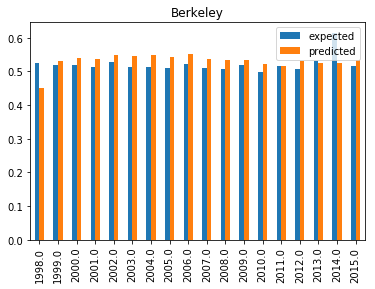

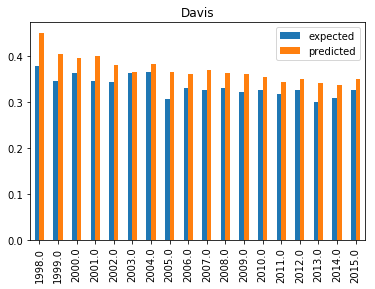

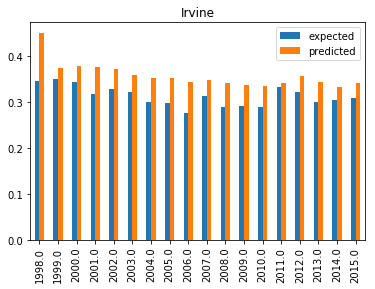

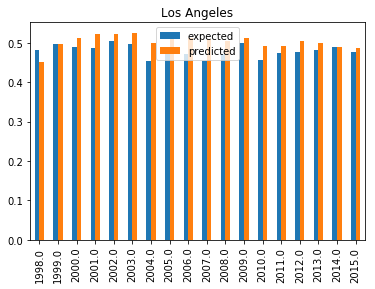

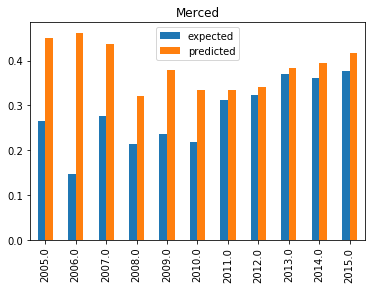

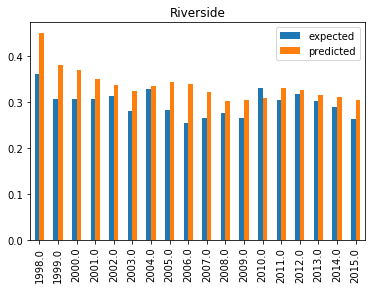

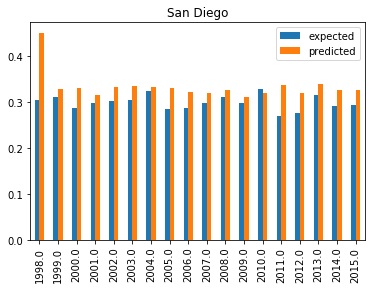

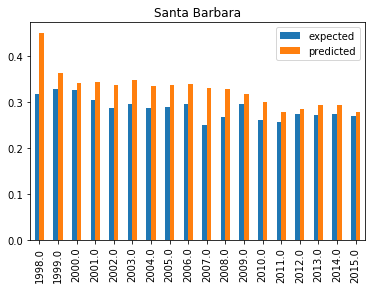

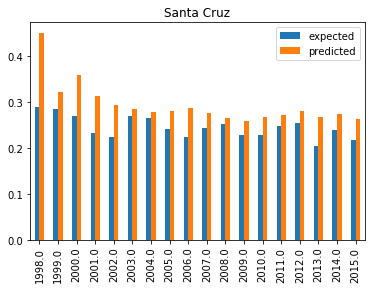

In [43]:
for campus in data['campus'].unique():
    campus_data = get_data_for_campus(data, campus)
    data_split = get_training_split(campus_data, .7)
    base_pred = baseline_pred(
        campus_data,
        campus_data['school_num'],
        campus_data['year']
    )
    
    yearly = predictions_to_yearly(campus_data, campus_data['school_num'], campus_data['year'], base_pred)
    result_matrix = pd.DataFrame(evaluate_yearly_predictions(yearly, get_year_yields(campus_data))).T
    display(campus, result_matrix)
    result_matrix[['expected','predicted']].plot(kind='bar', title=campus)

## Preparing and fitting a linear regressor

### Choosing the model

We are performing a regression, so that means we should not use classification algorithms such as nearest neighbors, logistic regression, SVMs, or decision trees. Two remaining possibilities would have been to use linear regression or a neural network, but we don’t think this problem is complex enough to warrant the added difficulties, complications, and lack of interpretability that a neural network would add. Thus, we decided to use a simple linear regression model. It was a good choice because it was fast to run over our many different experiments that we performed, easy to understand how it behaved so we could better troubleshoot with our rapid development schedule, and descriptive enough to adequately predict the relatively simple problem we were tackling.

### Other possible models

- **Using wide datapoints** - one for each year. The datapoints would include the following features:
  - For each school:
      - Number of applied
      - Number of accepted
      - GPA of applied
      - GPA of accepted
      - SAT scores
      - AP scores
      - High school enrollment
      - High school distance from the UC campus
  - Year
  
 We decided against using that model. One of the main reasons was insufficient time to experiment with combined features (we believe that we should multiply each feature but the number of accepted students).

- **Wide datapoints with random sampling.** - as above, but we would generate random datapoints where only sum of the high schools will be set. This way, we can overcome one of the most significant problems of the model above - an extremely small number of datapoints.

- Using this method above, we should be able to create enough data points for running a Neural Net
  


In [44]:
from sklearn.linear_model import LinearRegression

def prepare_linear_reg_model(data_split):
    reg = LinearRegression()
    reg.fit(data_split['z_inputs_training_set'], data_split['z_outputs_training_set'])    
    return reg

def evaluate_linear_reg_model(reg, data_split):
    y_pred = reg.predict(data_split['z_inputs_test_set'])
    eval_result = pd.DataFrame(data={
        'z-actual':data_split['z_outputs_test_set'].values.flatten(),
        'z-predicted':y_pred.flatten(),
        'school_num': data_split['original']['school_num'][data_split['test_filter']].values.flatten(),
        'year': data_split['original']['year'][data_split['test_filter']].values.flatten(),
        'predicted': undo_z_score(y_pred.flatten(), data_split['outputs_training_set']['yield'])
    })
    return eval_result

def extract_yearly_predictions(d_split, eval_results):
    yearly = predictions_to_yearly(
        d_split['original'],
        eval_results['school_num'],
        eval_results['year'],
        eval_results['predicted']
    )
    yearly_eval_res = evaluate_yearly_predictions(yearly, get_year_yields(d_split['original']))
    return pd.DataFrame(yearly_eval_res).T

'Berkeley'

,predicted,school_num,year,z-actual,z-predicted
0,0.623957,3833241.0,2012.0,-0.921710,0.237178
1,0.611597,3833241.0,2012.0,-0.921710,0.173221
2,0.777346,3833241.0,2012.0,1.536225,1.030907
3,0.777965,3833241.0,2012.0,1.443821,1.034108
4,0.709182,3833241.0,2012.0,0.301377,0.678184
5,0.742727,3833241.0,2012.0,0.889400,0.851762
6,0.606805,730283.0,2012.0,0.458183,0.148421
7,0.634226,730283.0,2012.0,2.183049,0.290316
8,0.618830,730283.0,2012.0,-0.404250,0.210647
9,0.515055,1930080.0,2012.0,0.630670,-0.326348


'Berkeley'

,adm,expected,predicted,predicted_enr,rms
2012.0,2887.0,0.508370,0.547020,1579.246262,0.001494
2013.0,2961.0,0.531194,0.547706,1621.756156,0.000273
2014.0,3790.0,0.614979,0.541542,2052.442602,0.005393
2015.0,4416.0,0.514804,0.533181,2354.525872,0.000338


Regressor score for Berkeley 0.22632581215897543


'Davis'

,predicted,school_num,year,z-actual,z-predicted
0,0.412011,3833241.0,2012.0,0.865467,0.086104
1,0.420355,3833241.0,2012.0,0.936941,0.134837
2,0.296993,730283.0,2012.0,-0.547226,-0.585648
3,0.384977,730283.0,2012.0,0.405315,-0.071786
4,0.345012,730283.0,2012.0,-0.904350,-0.305195
5,0.355991,4338802.0,2012.0,-1.289545,-0.241072
6,0.374796,4338802.0,2012.0,-1.421681,-0.131248
7,0.196022,1930080.0,2012.0,-1.097795,-1.175356
8,0.225743,1930080.0,2012.0,-1.111846,-1.001775
9,0.178936,130229.0,2012.0,-0.196423,-1.275147


'Davis'

,adm,expected,predicted,predicted_enr,rms
2012.0,10740.0,0.324435,0.314255,3375.099898,1.036314e-04
2013.0,10096.0,0.300027,0.316715,3197.555628,2.784937e-04
2014.0,9269.0,0.307536,0.307560,2850.774136,5.815918e-10
2015.0,8113.0,0.324724,0.338539,2746.564662,1.908508e-04


Regressor score for Davis 0.2745965242323214


'Irvine'

,predicted,school_num,year,z-actual,z-predicted
0,0.392813,3833241.0,2012.0,-0.481128,0.236186
1,0.401318,3833241.0,2012.0,-0.149015,0.291270
2,0.273818,3833241.0,2012.0,-0.526794,-0.534451
3,0.274183,3833241.0,2012.0,-0.526794,-0.532088
4,0.354354,5631619.0,2012.0,-0.065986,-0.012883
5,0.369053,5631619.0,2012.0,0.467767,0.082316
6,0.205017,130229.0,2012.0,-1.363305,-0.980020
7,0.213835,130229.0,2012.0,-1.360014,-0.922912
8,0.366775,1933852.0,2012.0,-0.226112,0.067561
9,0.387044,1933852.0,2012.0,-0.149015,0.198826


'Irvine'

,adm,expected,predicted,predicted_enr,rms
2012.0,10396.0,0.321623,0.341063,3545.692933,0.000378
2013.0,11014.0,0.299099,0.334195,3680.823194,0.001232
2014.0,10177.0,0.304795,0.333191,3390.887985,0.000806
2015.0,9765.0,0.307713,0.344835,3367.318315,0.001378


Regressor score for Irvine 0.17486125008252418


'Los Angeles'

,predicted,school_num,year,z-actual,z-predicted
0,0.600667,3833241.0,2012.0,0.544540,0.278534
1,0.622261,3833241.0,2012.0,0.166366,0.390058
2,0.681693,3833241.0,2012.0,2.340866,0.696988
3,0.525739,3833241.0,2012.0,0.016870,-0.108426
4,0.538585,3833241.0,2012.0,0.214333,-0.042085
5,0.574563,5631619.0,2012.0,-0.241352,0.143721
6,0.607845,5631619.0,2012.0,0.865313,0.315606
7,0.516747,1930080.0,2012.0,0.533313,-0.154865
8,0.549533,1930080.0,2012.0,1.943602,0.014457
9,0.331109,130229.0,2012.0,-0.848933,-1.113580


'Los Angeles'

,adm,expected,predicted,predicted_enr,rms
2012.0,5187.0,0.477647,0.506140,2625.349406,0.000812
2013.0,4626.0,0.481190,0.508889,2354.120180,0.000767
2014.0,4805.0,0.489785,0.504187,2422.616369,0.000207
2015.0,4419.0,0.475492,0.505942,2235.759315,0.000927


Regressor score for Los Angeles 0.33002530978351907


'Merced'

,predicted,school_num,year,z-actual,z-predicted
0,0.333219,130229.0,2014.0,-0.986177,-0.157652
1,0.389837,130229.0,2014.0,-1.034951,0.159230
2,0.416542,4332995.0,2014.0,0.775794,0.308694
3,0.456031,4332995.0,2014.0,3.574219,0.529706
4,0.475306,122721.0,2014.0,0.309390,0.637584
5,0.486486,122721.0,2014.0,0.216109,0.700156
6,0.469362,2430601.0,2014.0,0.439983,0.604319
7,0.514082,2430601.0,2014.0,0.281954,0.854606
8,0.441195,112508.0,2014.0,0.775794,0.446671
9,0.446905,112508.0,2014.0,1.086730,0.478627


'Merced'

,adm,expected,predicted,predicted_enr,rms
2014.0,1490.0,0.361940,0.411920,613.761254,0.002498
2015.0,1303.0,0.376022,0.441263,574.965748,0.004256


Regressor score for Merced 0.04792784512808923


'Riverside'

,predicted,school_num,year,z-actual,z-predicted
0,0.384479,3833241.0,2012.0,-0.343070,0.224798
1,0.417213,3833241.0,2012.0,-0.687981,0.425078
2,0.432742,3833241.0,2012.0,0.494571,0.520086
3,0.081805,130229.0,2012.0,-0.903925,-1.627090
4,0.093633,130229.0,2012.0,-0.950990,-1.554722
5,0.316556,1933852.0,2012.0,-0.829763,-0.190789
6,0.365976,1933852.0,2012.0,-0.195476,0.111588
7,0.262388,1930163.0,2012.0,-0.220569,-0.522210
8,0.290159,1930163.0,2012.0,-0.231761,-0.352294
9,0.235575,3030574.0,2012.0,-0.401901,-0.686265


'Riverside'

,adm,expected,predicted,predicted_enr,rms
2012.0,10576.0,0.317525,0.300041,3173.236170,0.000306
2013.0,10479.0,0.301889,0.274077,2872.048550,0.000774
2014.0,11167.0,0.287842,0.273571,3054.967224,0.000204
2015.0,11992.0,0.261737,0.277411,3326.707011,0.000246


Regressor score for Riverside 0.1938697645670637


'San Diego'

,predicted,school_num,year,z-actual,z-predicted
0,0.310321,5631619.0,2012.0,0.263551,-0.261329
1,0.340860,5631619.0,2012.0,-0.872055,-0.067117
2,0.347915,5631619.0,2012.0,1.580855,-0.022252
3,0.297020,4338802.0,2012.0,0.591615,-0.345915
4,0.314364,4338802.0,2012.0,0.442858,-0.235614
5,0.340008,4338802.0,2012.0,1.399158,-0.072537
6,0.281885,1930080.0,2012.0,-0.821583,-0.442166
7,0.340142,1930080.0,2012.0,-0.114984,-0.071682
8,0.314748,1930080.0,2012.0,-1.326297,-0.233177
9,0.135117,130229.0,2012.0,-0.473719,-1.375523


'San Diego'

,adm,expected,predicted,predicted_enr,rms
2012.0,7912.0,0.274457,0.294837,2332.747410,4.153488e-04
2013.0,8716.0,0.314476,0.301178,2625.065102,1.768406e-04
2014.0,7856.0,0.290196,0.290214,2279.922206,3.258643e-10
2015.0,8235.0,0.293669,0.310381,2555.985258,2.792873e-04


Regressor score for San Diego 0.2292521057766406


'Santa Barbara'

,predicted,school_num,year,z-actual,z-predicted
0,0.172856,3030574.0,2012.0,-0.882750,-1.125422
1,0.320602,3030574.0,2012.0,-0.733721,-0.198549
2,0.265010,3030574.0,2012.0,-0.995608,-0.547300
3,0.344552,4830170.0,2012.0,-0.249378,-0.048306
4,0.433615,112045.0,2012.0,1.275404,0.510427
5,0.434647,112045.0,2012.0,1.275404,0.516896
6,0.185015,102871.0,2012.0,-0.931900,-1.049139
7,0.277514,102871.0,2012.0,-0.879094,-0.468861
8,0.390972,3830288.0,2012.0,-0.228742,0.242907
9,0.400387,3830288.0,2012.0,0.004325,0.301971


'Santa Barbara'

,adm,expected,predicted,predicted_enr,rms
2012.0,6108.0,0.273284,0.279477,1707.044938,0.000038
2013.0,6763.0,0.271417,0.255873,1730.469323,0.000242
2014.0,6515.0,0.273857,0.265214,1727.868441,0.000075
2015.0,5547.0,0.269879,0.266606,1478.865640,0.000011


Regressor score for Santa Barbara 0.28315535561108207


'Santa Cruz'

,predicted,school_num,year,z-actual,z-predicted
0,0.374062,3833241.0,2012.0,1.160246,0.524173
1,0.385205,3833241.0,2012.0,1.389201,0.600716
2,0.304760,3833241.0,2012.0,-0.724235,0.048159
3,0.299257,3833241.0,2012.0,-0.698335,0.010362
4,0.354400,3833241.0,2012.0,-0.264367,0.389126
5,0.383764,3833241.0,2012.0,0.244423,0.590816
6,0.200828,730283.0,2012.0,-0.695930,-0.665710
7,0.254459,730283.0,2012.0,-0.380001,-0.297339
8,0.321989,4338802.0,2012.0,0.162654,0.166502
9,0.235498,1930080.0,2012.0,-1.086714,-0.427577


'Santa Cruz'

,adm,expected,predicted,predicted_enr,rms
2012.0,7190.0,0.254231,0.266681,1917.436621,0.000155
2013.0,5474.0,0.204748,0.254308,1392.083146,0.002456
2014.0,8757.0,0.237689,0.251614,2203.384358,0.000194
2015.0,6722.0,0.215805,0.242467,1629.862417,0.000711


Regressor score for Santa Cruz 0.34539233090894894


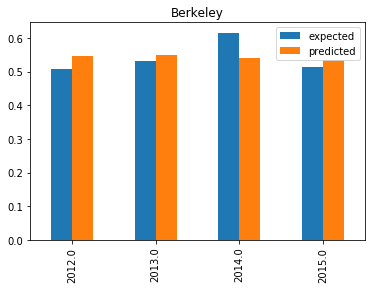

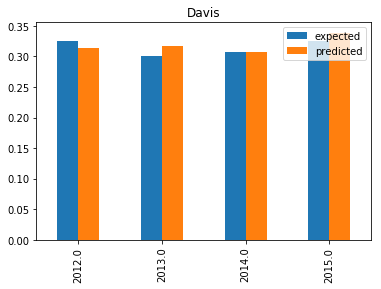

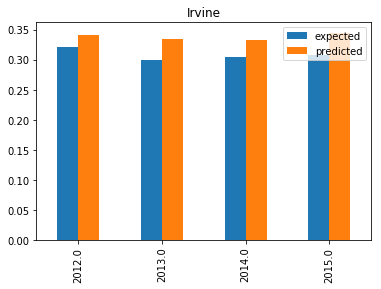

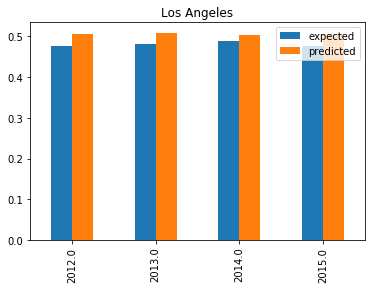

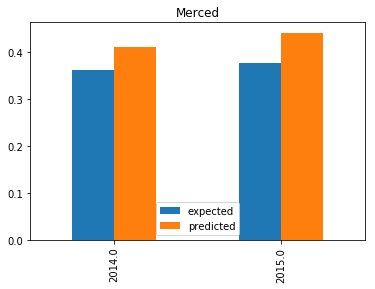

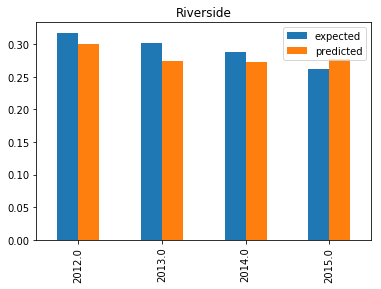

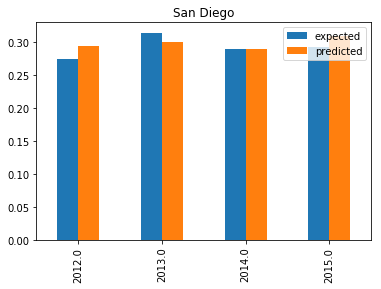

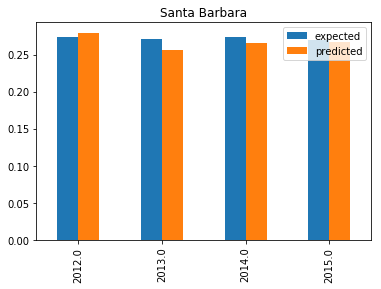

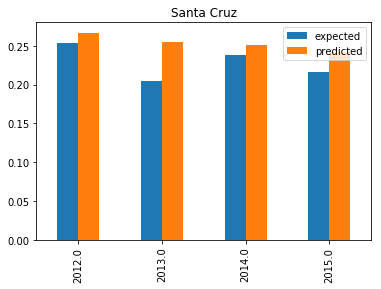

In [45]:
regressor_results = {}

for campus in data['campus'].unique():
    campus_resuts = {}
    regressor_results[campus] = campus_resuts
    
    d_split = get_training_split(get_data_for_campus(data, campus), .7)
    
    model = prepare_linear_reg_model(d_split)
    per_school_results = evaluate_linear_reg_model(model, d_split)
    display(campus, per_school_results)
    campus_resuts['per_school'] = per_school_results
    
    yearly_pred_eval = extract_yearly_predictions(d_split, per_school_results)
    campus_resuts['yearly'] = yearly_pred_eval
    display(campus, yearly_pred_eval)
    yearly_pred_eval[['expected', 'predicted']].plot.bar(title=campus)
    
    print('Regressor score for', campus, model.score(
        data_split['z_inputs_test_set'], data_split['z_outputs_test_set']
    ))


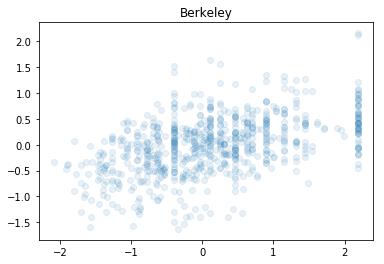

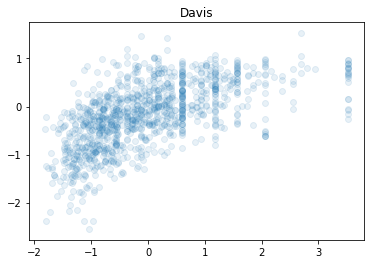

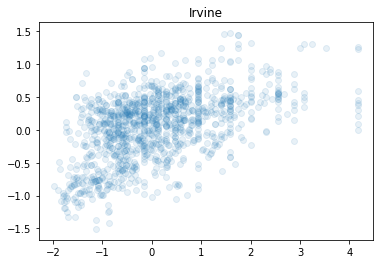

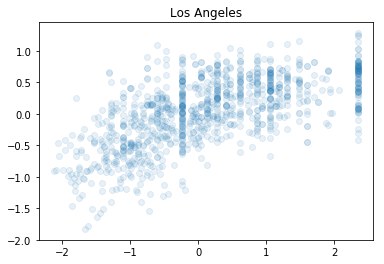

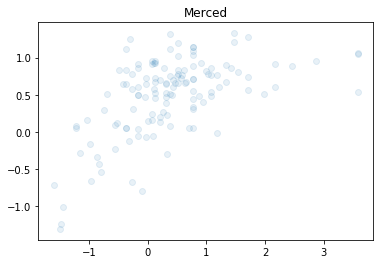

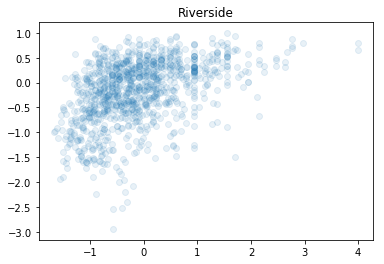

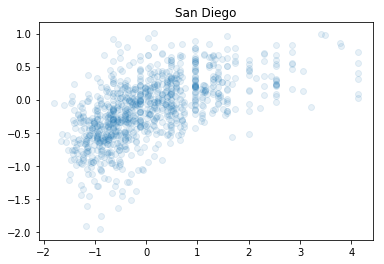

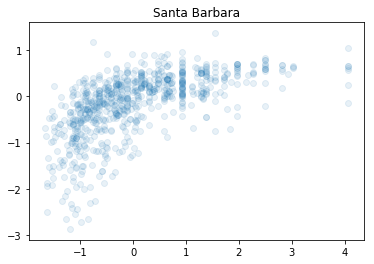

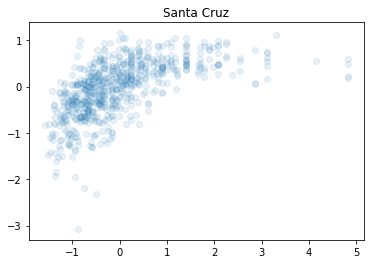

In [46]:
for campus in regressor_results:
    plt.scatter(
        regressor_results[campus]['per_school']['z-actual'].values.flatten(),
        regressor_results[campus]['per_school']['z-predicted'].values.flatten(),
        alpha=.1
    )
    plt.title(campus)
    plt.show()

In [47]:
# import statsmodels.api as sm
# X_train2 = sm.add_constant(X_train)
# est = sm.OLS(y_train, X_train2)
# est2 = est.fit()
# est2.summary()

## Results

Both our baseline model and linear regression model suggested us that the yield rate would stay at around 45% - 50%, which is a solid prediction. 
